In [12]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
# radius of the oberservation circle
def NMLA_radius(omega,Rest=1):
    # Input: omega--frequency; Rest--estimate of the distance from source to observation point
    #
    # Output: the radius of the oberservation circle
    
    poly = [1,0,1,-2.5-0.775*(omega*Rest)**0.5];
    rt = np.roots(poly);
    rs = np.real(rt[2])**3/omega
    return rs

In [19]:
# NMLA filtering in the fourier space
def BGFiltrage(fu,kr,imp,L,gau,M):
    # INPUT: fu: FFT of impedance quantity U
    #        kr: k*r
    #        imp: parameter in impedance quantity
    #        L: truncation level
    #        gau: parameter in gaussian kernel
    #        M: number of sample points on the observation cicle
    #
    # OUTPUT: filterd quantity BU
    #
    
    # bessel and derivative of bessel
    LP = max( L+2, 3) 
    idx = np.array(list(range(LP)))
    Bj = sp.jv(idx, kr)  # bessel J_l(kr)
    DBj = np.array([0.0]*(LP-1))
    DBj[0] = -Bj[1]
    DBj[1:] = 0.5*(Bj[:LP-2] - Bj[2:LP])  # derivative of bessel
    
    # gausian kernel
    A = gau/L
    G = np.array([0.0]*(L+1))
    G[0] = 1.0
    idx = np.array(list(xrange(1,L+1)))
    G[1:] = np.exp(-0.5*(A*idx)**2)
    G /= 2*np.sum(G) - 1
    
    # filtering operator
    Fltr = np.array([0.0 + 0.0*1j]*(L+1))
    Fltr[0] = Bj[0]-1j*DBj[0]*imp
    Fltr[1:] = (Bj[1:L+1]-1j*DBj[1:L+1]*imp)*(1j**idx)
    Fltr = G/Fltr
    
    fb = np.array([0.0 + 0.0*1j]*(M))
    fb[0] = Fltr[0]*fu[0]                # FU_0
    fb[idx] = Fltr[idx]*fu[idx]          # FU_{1,...,L} 
    fb[M-idx] = Fltr[idx]*fu[M-idx]      # FU_{-1,...,-L} 
    
    return fb
    
    

In [43]:
def NMLA(x0,y0,c0,omega,Rest,u,ux,uy):
    imp = 0.5 ;                # parameter in impedance quantity
    gau = 3.5 ;                # Parameter in Gaussian function
    
    r = NMLA_radius(omega,Rest);

    kr = r*omega/c0;                      # k*r
    L = int(round(kr + (kr)**(1.0/3) -2.5));      # truncation level to obtain needed precision
    L = max(1,L) ;
    M = 2*(4*L)+1;                        # number of samples on the observation circle


    # Angle discretizaion on the circle
    angl = np.linspace(0,2*np.pi,M+1) ;  
    ang = angl[:M] ;
    X = x0 + r*np.cos(ang) ;
    Y = y0 + r*np.sin(ang) ;
    
    # compute the impedance quantity
    Field = u(X, Y, omega)
    DUx = ux(X, Y, omega)
    DUy = uy(X, Y, omega)

    DField = DUx*np.cos(ang) + DUy*np.sin(ang)
    U = imp*DField/(1j*omega/c0) + Field;
    
    # filtering
    fu = np.fft.fft(U) 
    fbeta = BGFiltrage(fu,kr,imp,L,gau,M) 
    beta = np.fft.ifft(fbeta)   
    
    # estimate the ray angle
    sorted_index = sorted(range(len(beta)),key=lambda x:abs(beta[x]), reverse = True)
    est_ang = ang[sorted_index[0]]

    # plot
    plt.plot(ang,np.abs(beta))
    
    return est_ang

In [4]:
    x0, y0 = 0.0, 0.0              # observation point
    c0 = 1.0                     # wavespeed at observation point
    omega = 1000.0               # frequency
    Rest = 3.0                   # estimate of the distance from source to oberservation point
    imp = 0.5 ;                # parameter in impedance quantity
    gau = 3.5 ;                # Parameter in Gaussian function
    
    r = NMLA_radius(omega,Rest);

    kr = r*omega/c0;                      # k*r
    L = int(round(kr + (kr)**(1.0/3) -2.5));      # truncation level to obtain needed precision
    L = max(1,L) ;
    M = 2*(4*L)+1;                        # number of samples on the observation circle


    # Angle discretizaion on the circle
    angl = np.linspace(0,2*np.pi,M+1) ;  
    ang = angl[:M] ;
    X = x0 + r*np.cos(ang) ;
    Y = y0 + r*np.sin(ang) ;
    

In [6]:
# Add source 
xs, ys = 2, 2
rxy = lambda x, y: np.sqrt((x-xs)**2 + (y-ys)**2)
u = lambda x, y, omega: 1j/4*np.sqrt(omega)*sp.hankel1(0, omega*rxy(x,y))
ux = lambda x, y, omega: -1j/4*(omega**1.5)*sp.hankel1(1,omega*rxy(x,y))*(x-xs)/rxy(x,y)
uy = lambda x, y, omega: -1j/4*(omega**1.5)*sp.hankel1(1,omega*rxy(x,y))*(y-ys)/rxy(x,y)

In [10]:
# compute the impedance quantity
Field = u(X, Y, omega)
DUx = ux(X, Y, omega)
DUy = uy(X, Y, omega)

DField = DUx*np.cos(ang) + DUy*np.sin(ang)
U = imp*DField/(1j*omega/c0) + Field;


In [37]:
# filtering
fu = np.fft.fft(U) 
fbeta = BGFiltrage(fu,kr,imp,L,gau,M) 
beta = np.fft.ifft(fbeta)    
sorted_index = sorted(range(len(beta)),key=lambda x:abs(beta[x]), reverse = True)
est_ang = ang[sorted_index[0]]

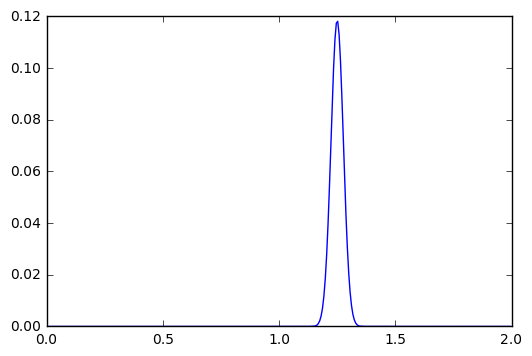

In [24]:
plt.plot(ang/np.pi,np.abs(beta))

In [22]:
ang.shape, beta.shape, fu.shape, M

((337,), (337,), (337,), 337)

In [38]:
est_ang/np.pi

1.252225519287834

In [28]:
?sorted

In [35]:
a = [1,4,3,2]
b= sorted(range(len(a)),key=lambda x:a[x], reverse = True)

In [36]:
b[0]

1

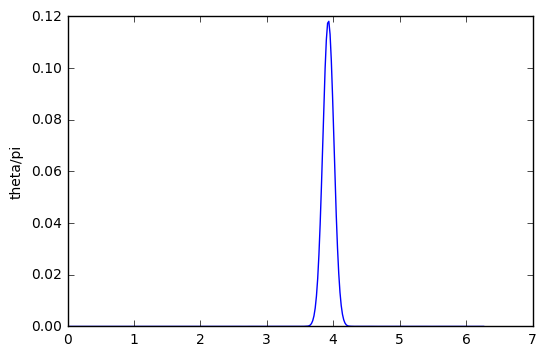

In [57]:
NMLA(x0,y0,c0,omega,Rest,u,ux,uy)
plt.ylabel('theta/pi')

In [53]:
import math
math.atan2(-1,-1)/np.pi + 2

1.25